In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from google.colab import files
import io, requests, zipfile
from sklearn.cluster import KMeans

Read Parimah's data with a little preparation (for instance I removed '$' and ',' for more convenience)

In [3]:
data = pd.read_csv('/Users/apple/Desktop/COVID-19-economical-effects/risk_income_data.csv')
n_s = 100
data.head()

,occ,risk,income,number,medical staff or not
0,Waiters and Waitresses,43.6,21780,2582410,0
1,Amusement and Recreation Attendants,56.0,22260,319890,0
2,"Ushers, Lobby Attendants, and Ticket Takers",51.1,22260,133970,0
3,Dining Room and Cafeteria Attendants and Barte...,45.5,22270,455700,0
4,"Counter Attendants, Cafeteria, Food Concession...",39.5,22330,473860,0


In [4]:
print(data.shape)

(100, 5)


In [5]:
#keep the features (risk, income and number) in X_p and scale them with it's corresponding maximum value
X = data.drop('occ', axis=1)
X_max = X.max(axis = 0)
X = X / X_max

medic_list = X[X['medical staff or not'] == 1]
X = X[X['medical staff or not'] != 1]

medic_list = medic_list.drop('medical staff or not', axis=1)
X = X.drop('medical staff or not', axis=1)

print(X.shape)
print(medic_list.shape)

(68, 3)
(32, 3)


In the following we intend to:
1-classify jobs to get a sense of what we are working with. We have so far 3 dimensions. We can classify jobs only base on [risk, income] or we can classify them in a 3d space where the features are [risk, income, number]
2-for each 2 pairs of features, plot them in different colors.

We use Unsupervised clustering KMeans method. MUST INDICATE THE NUMBER OF CLUSTERS.

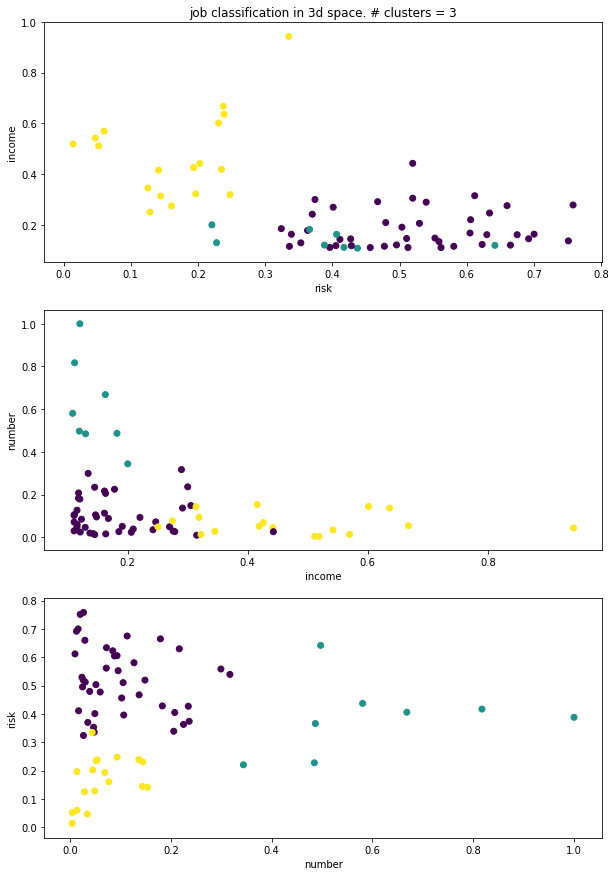

In [6]:
#Unsupervised clustering, THREE features (risk, number and income), THREE clusters.

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (10,15))
axs = [ax1,ax2,ax3]
N_clusters = 3
N_space = 3

y_pred = KMeans(n_clusters=3, random_state=1).fit_predict(X)

features = ['risk', 'income', 'number']
features_r = ['income', 'number', 'risk']


for i in range(3):
    feat_1 = features[i]
    feat_2 = features_r[i]
    axs[i].scatter(X[feat_1],  X[feat_2], c=y_pred)
    axs[i].set_xlabel(feat_1)
    axs[i].set_ylabel(feat_2)
    if i == 0:
        axs[i].set_title('job classification in {}d space. # clusters = {}'.format(N_space, N_clusters))


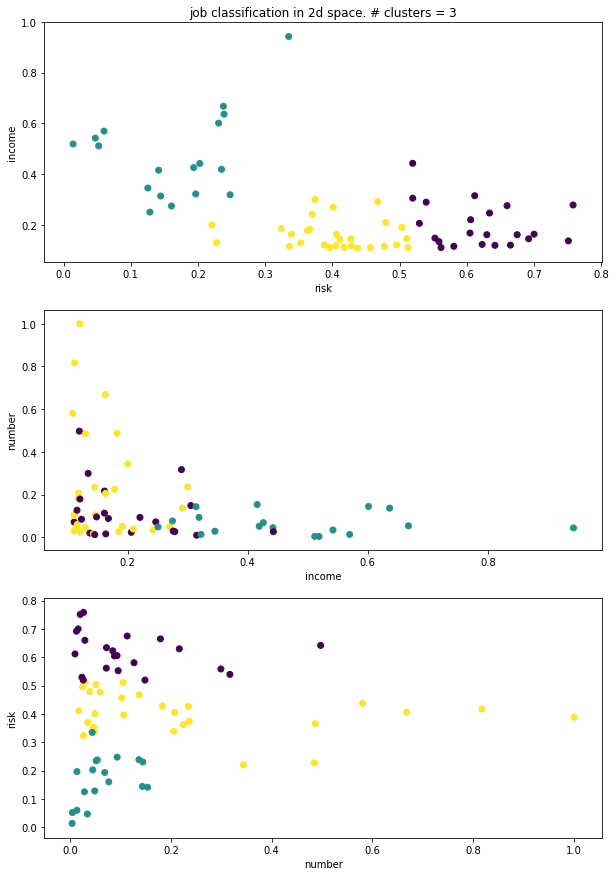

In [7]:
#Unsupervised clustering, TWO features (risk and income), THREE clusters
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (10,15))
axs = [ax1,ax2,ax3]
X_p = X.drop('number', axis = 1)

N_clusters = 3
N_space = 2

y_pred = KMeans(n_clusters=3, random_state=10).fit_predict(X_p)
features = ['risk', 'income', 'number']
features_r = ['income', 'number', 'risk']

for i in range(3):
    feat_1 = features[i]
    feat_2 = features_r[i]
    axs[i].scatter(X[feat_1],  X[feat_2], c=y_pred)
    axs[i].set_xlabel(feat_1)
    axs[i].set_ylabel(feat_2)
    if i == 0:
        axs[i].set_title('job classification in {}d space. # clusters = {}'.format(N_space, N_clusters))


Based on the last plot, one can ignore the "green" cluster (AKA medical staff). This group's characteristics: [High income, High risk, Low number]

In [8]:
X['risk_groups'] = y_pred
X['risk_groups'].head()

medic_list['risk_groups'] = len(medic_list) * [3]

In [12]:
X_final = [X,medic_list]
X_final = pd.concat(X_final)
X_final.shape


(100, 4)

In [13]:
# determining the average risk and income in each group

mean_risk = [0,0,0,0]
mean_income = [0,0,0,0]
pop_per_gr = [0,0,0,0]

for i in range(len(X_final)):
    if X_final['risk_groups'][i] == 0:
        mean_risk[0] += X_final['risk'][i] * X_final['number'][i]        # if you want the averages over jobs instead of population
        mean_income[0] += X_final['income'][i] * X_final['number'][i]    # , delete the last term
        pop_per_gr[0] += X_final['number'][i]                     #1 and set this to 1
    if X_final['risk_groups'][i] == 1:
        mean_risk[1] += X_final['risk'][i] * X_final['number'][i]
        mean_income[1] += X_final['income'][i] * X_final['number'][i]    
        pop_per_gr[1] += X_final['number'][i]
    if X_final['risk_groups'][i] == 2:
        mean_risk[2] += X_final['risk'][i] * X_final['number'][i]
        mean_income[2] += X_final['income'][i] * X_final['number'][i]
        pop_per_gr[2] += X_final['number'][i]
    if X_final['risk_groups'][i] == 3:
        mean_risk[3] += X_final['risk'][i] * X_final['number'][i]
        mean_income[3] += X_final['income'][i] * X_final['number'][i]
        pop_per_gr[3] += X_final['number'][i]
        
mean_risk = np.array(mean_risk) / np.array(pop_per_gr)
mean_income = np.array(mean_income) / np.array(pop_per_gr)

group_labels = ['high risk', 'medium risk', 'low risk', 'medical staff']

In [14]:
group_labels


['high risk', 'medium risk', 'low risk', 'medical staff']

In [15]:
d = pd.DataFrame()
d['group label'] = group_labels
d['risk'] = np.round(mean_risk, 2)
d['average income'] = np.round(mean_income, 2)
d['population'] = np.round(pop_per_gr,2)
d

,group label,risk,average income,population
0,high risk,0.60,0.18,2.57
1,medium risk,0.19,0.47,1.16
2,low risk,0.38,0.15,6.55
3,medical staff,0.78,0.30,2.28


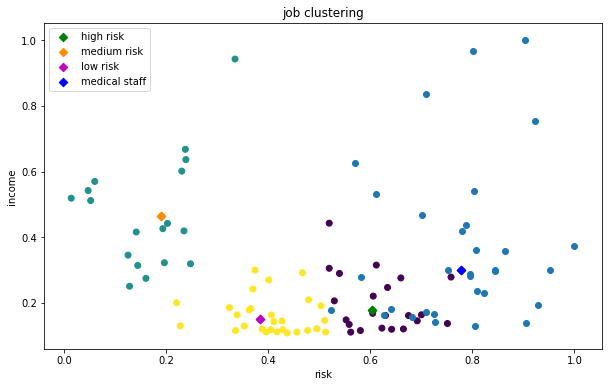

In [25]:
# plotting income vs risk for each grous and their average risks and incomes

fig, ax = plt.subplots(figsize = (10,6))
ax.set_xlabel('risk')
ax.set_ylabel('income')
ax.set_title('job clustering')

colors = ['m','darkorange','green',,,'blue']
for i in range(4):
    ax.scatter(mean_risk[i], mean_income[i], color = colors[i] ,marker = 'D', label = group_labels[i])
ax.legend()

ax.scatter(X_final['risk'][:68],  X_final['income'][:68], c=y_pred)
ax.scatter(X_final['risk'][68:],  X_final['income'][68:])

for i in range(4):
    ax.scatter(mean_risk[i], mean_income[i], color = colors[i] ,marker = 'D')